In [50]:
import pandas as pd
import numpy as np

In [3]:
pd.options.display.max_columns = 100

In [4]:
import matplotlib.pyplot as plt
import matplotlib as mpl

In [25]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [6]:
import geopandas as gpd

In [7]:
dt = pd.read_csv("~/misc/corporate_finance_II/pset 3/branches.csv", encoding='latin1')

In [9]:
# construct cntycode by State_FIPS + cntynumb
dt = pd.read_csv("state_fips.csv").rename(columns = {"Postal Code": "stalpbr"}).merge(dt)
dt['cntycode'] = dt.FIPS * 1000 + dt.cntynumb

## 2)

In [32]:
dt['zip'] = dt.zipbr // 100

In [33]:
brcount = dt.groupby(['zip', 'year', 'rssdid'])['brnum'].count().reset_index()

In [54]:
brcount['total_num'] = brcount.groupby(['zip', 'year'])['brnum'].transform('sum')

In [55]:
brcount.eval('share = brnum / total_num', inplace = True)

In [56]:
brcount.eval('bhi = share * share', inplace = True)

In [59]:
BHI = brcount.groupby(['zip', 'year']).bhi.sum().reset_index()

### b) summary statistics

In [161]:
BHI.query("2015 <= year <= 2017").groupby("year").bhi.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2015,891.0,0.106757,0.077033,0.024732,0.069360,0.090248,0.121382,1.0
2016,891.0,0.107536,0.077510,0.024979,0.069210,0.090844,0.122106,1.0
2017,891.0,0.108769,0.078220,0.024750,0.069682,0.091237,0.123627,1.0


In [60]:
BHI2017 = BHI.query("year == 2017")

In [70]:
BHI2017['quartile'] = pd.qcut(BHI2017.bhi, 4, labels = [1, 2, 3, 4])

/home/zhiyufu/.conda/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### c) Drawing maps

Download the data first.

In [5]:
# import urllib.request

# url = 'http://faculty.baruch.cuny.edu/geoportal/data/esri/usa/census/zip3.zip'
# urllib.request.urlretrieve(url, 'map/zipcode.zip')

# import os

# os.system("unzip map/zipcode.zip -d map/")

In [27]:
mpdf = gpd.read_file("map")

In [76]:
mpdf['ZIP3'] = mpdf.ZIP3.astype('int')

In [84]:
mpdf = mpdf.set_index("ZIP3").join(BHI2017.set_index('zip'))

KeyError: "None of ['ZIP3'] are in the columns"

In [111]:
mpdf = mpdf.query("POP2012 != -99 and ~(STATE in ['AK', 'RI', 'HI']) and quartile.notna()")

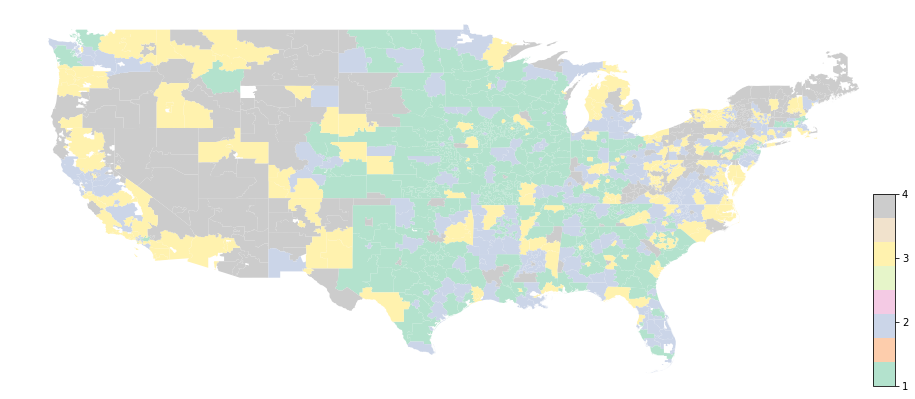

In [158]:
fig, ax = plt.subplots(1, figsize = (16, 9))
heatmap = mpdf.plot(column = 'quartile', cmap = 'Pastel2', ax = ax)
ax.axis('off')
axins1 = inset_axes(ax, width="2.5%", height="50%", loc='lower right')
sm = plt.cm.ScalarMappable(cmap='Pastel2', norm = plt.Normalize(vmin=1, vmax=4))
cbar = fig.colorbar(sm, cax = axins1, ticks = [1,2,3,4])

# 3)

In [164]:
# url = 'https://www2.census.gov/geo/tiger/TIGER2017/COUNTY/tl_2017_us_county.zip'
# urllib.request.urlretrieve(url, 'county_map/county.zip')

# os.system("unzip county_map/county.zip -d county_map/")

In [10]:
ctdf = gpd.read_file("county_map")

In [12]:
ctdf['cntycode'] = ctdf.STATEFP.astype('int') * 1000 + ctdf.COUNTYFP.astype('int')

In [13]:
ctdep = dt.groupby(['year', 'cntycode', 'rssdid'])['depsumbr'].agg('sum').reset_index()

In [14]:
ctdep['depsum'] = ctdep.groupby(['year', 'cntycode']).depsumbr.transform('sum')

In [15]:
ctdep['share'] = ctdep.depsumbr / ctdep.depsum

In [16]:
ctdep['bhi'] = ctdep.share * ctdep.share

In [17]:
ctbhi = ctdep.groupby(['year', 'cntycode']).bhi.sum().reset_index()

In [18]:
ctbhi2017 = ctbhi.query('year == 2017')

In [19]:
ctbhi2017['quartile'] = pd.qcut(ctbhi2017.bhi, 4, labels = [1, 2, 3, 4])

/home/zhiyufu/.conda/envs/python3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
ctbhi2017 = ctdf.set_index('cntycode').join(ctbhi2017.set_index('cntycode'))

In [21]:
ctbhi.query("2015 <= year <= 2017").groupby("year").bhi.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2015,3196.0,0.333432,0.221543,0.054042,0.180359,0.268814,0.409967,1.0
2016,3192.0,0.334944,0.223097,0.054377,0.179444,0.268666,0.410064,1.0
2017,3193.0,0.337317,0.223525,0.000000,0.182184,0.271457,0.410876,1.0


In [22]:
ctbhi2017['STATEFP'] = ctbhi2017.STATEFP.astype('int')

In [23]:
ctbhi2017 = ctbhi2017.query("STATEFP<=56 and STATEFP not in [2, 44, 15] and quartile.notna()")

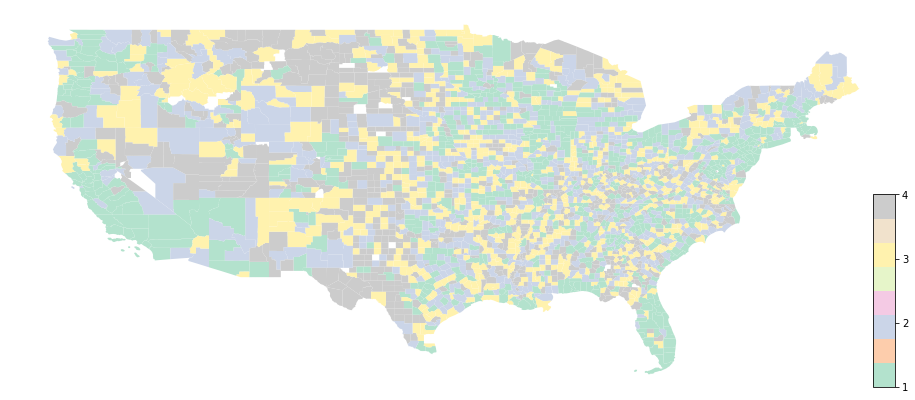

In [26]:
fig, ax = plt.subplots(1, figsize = (16, 9))
heatmap = ctbhi2017.plot(column = 'quartile', cmap = 'Pastel2', ax = ax)
ax.axis('off')
axins1 = inset_axes(ax, width="2.5%", height="50%", loc='lower right')
sm = plt.cm.ScalarMappable(cmap='Pastel2', norm = plt.Normalize(vmin=1, vmax=4))
cbar = fig.colorbar(sm, cax = axins1, ticks = [1,2,3,4])

# 4) Top and Bottom Banks

In [27]:
dt = dt.merge(ctbhi)

In [28]:
dt['wbhi'] = dt.depsumbr * dt.bhi
bank = dt.groupby(['year',  'rssdid'])[['wbhi', 'depsumbr']].sum().reset_index()

In [29]:
bank['wbhi'] = bank.wbhi/bank.depsumbr

In [30]:
bank_opstate = dt.groupby(['year', 'rssdid']).FIPS.nunique().rename("nstate").reset_index()

In [31]:
bank = bank.merge(bank_opstate)

In [32]:
bank = bank.query("nstate >=3")

In [33]:
bank = bank.query("1994 <= year <= 2013")

In [34]:
topbank = bank.groupby(['rssdid']).wbhi.agg('mean').reset_index().sort_values('wbhi', ascending = False).iloc[0:9, :]

In [35]:
top_depstate  = (topbank.merge(dt[['rssdid', 'stalpbr', 'depsumbr']], on = 'rssdid').
    groupby(['rssdid', 'stalpbr']).depsumbr.agg('sum').
    sort_values(ascending = False).reset_index().groupby('rssdid').head(3).
    groupby('rssdid')['stalpbr'].apply(lambda x: ', '.join(x)).rename("Top States (Deposits)")
)

In [36]:
top_brstate  = (topbank.merge(dt[['rssdid', 'stalpbr', 'depsumbr']], on = 'rssdid').
    groupby(['rssdid', 'stalpbr']).depsumbr.agg('count').
    sort_values(ascending = False).reset_index().groupby('rssdid').head(3).
    groupby('rssdid')['stalpbr'].apply(lambda x: ', '.join(x)).rename("Top States (Branches)")
)

In [38]:
topbank.merge(dt[['rssdid', 'namefull']].drop_duplicates(subset = 'rssdid')).set_index('rssdid').join(top_depstate).join(top_brstate)

,wbhi,namefull,Top States (Deposits),Top States (Branches)
rssdid,,,,
3441677,0.704306,E*TRADE Savings Bank,"VA, CA, NY","CA, NY, FL"
78559,0.693764,Summit National Bank,"WY, MT, ID","WY, MT, ID"
486752,0.491608,"Citibank (South Dakota), N.A.","SD, NV, UT","SD, NV, UT"
130943,0.467239,Irwin Union Bank and Trust Company,"IN, NV, MI","IN, MI, NV"
2352507,0.391631,BANKFIRST,"SD, MN, AZ","SD, MN, AZ"
72614,0.386790,Baltimore Trust Company,"DE, MD, VA","DE, MD, VA"
947132,0.359661,The Matewan National Bank,"WV, KY, VA","WV, KY, VA"
663245,0.320363,Simmons First National Bank of Pine Bluff,"AR, TN, MO","AR, MO, TN"
610164,0.319516,Herring Bank,"TX, OK, CO","TX, OK, CO"


In [39]:
bottombank = bank.groupby(['rssdid']).wbhi.agg('mean').reset_index().sort_values('wbhi', ascending = True).iloc[0:9, :]

In [40]:
bot_depstate  = (bottombank.merge(dt[['rssdid', 'stalpbr', 'depsumbr']], on = 'rssdid').
    groupby(['rssdid', 'stalpbr']).depsumbr.agg('sum').
    sort_values(ascending = False).reset_index().groupby('rssdid').head(3).
    groupby('rssdid')['stalpbr'].apply(lambda x: ', '.join(x)).rename("Top States (Deposits)")
)

In [41]:
bot_brstate  = (bottombank.merge(dt[['rssdid', 'stalpbr', 'depsumbr']], on = 'rssdid').
    groupby(['rssdid', 'stalpbr']).depsumbr.agg('count').
    sort_values(ascending = False).reset_index().groupby('rssdid').head(3).
    groupby('rssdid')['stalpbr'].apply(lambda x: ', '.join(x)).rename("Top States (Branches)")
)

In [42]:
bottombank.merge(dt[['rssdid', 'namefull']].drop_duplicates(subset = 'rssdid')).set_index('rssdid').join(bot_depstate).join(bot_brstate)

,wbhi,namefull,Top States (Deposits),Top States (Branches)
rssdid,,,,
611107,0.067236,CrossLand Federal Savings Bank,"NY, NJ, UT","NY, NJ, UT"
754433,0.068918,Mutual Bank,"IL, NJ, NY","IL, NJ, NY"
400253,0.073779,Hillcrest Bank,"KS, MO, TX","KS, MO, TX"
338673,0.074990,CFS Bank,"NY, NJ, CT","NY, NJ, CT"
83638,0.075394,"Commercebank, National Association","FL, TX, NY","FL, TX, NY"
32104,0.081522,"Anchor Savings Bank, FSB","NY, NJ, FL","NY, NJ, FL"
917975,0.081871,"Berkeley Federal Bank and Trust, F.S.B.","NJ, DE, MD","NJ, DE, MD"
141734,0.082218,South Shore Bank of Chicago,"IL, OH, MI","IL, MI, OH"
578,0.085242,"California Federal Bank, A FSB","CA, NV, FL","CA, NV, FL"


In [43]:
feddt = pd.read_excel("AggregateDataAndFigures.xlsx", sheet_name = "Data_Fig_1_Panel_A", usecols = ['quarter', 'Fed Funds Target Avg Quarter'])

In [44]:
feddt = (feddt.rename(columns = {'Fed Funds Target Avg Quarter' : 'fedrate'}).
         assign(year = lambda x: x.quarter.dt.year).
         groupby('year').fedrate.agg('mean').reset_index()
        )

In [45]:
feddt['Dfedrate'] = feddt.fedrate - feddt.fedrate.shift()

In [46]:
dt['nobs'] = dt.groupby('uninumbr').uninumbr.transform('count')

In [47]:
dt = dt.query('nobs >= 20')

In [48]:
dt = dt.sort_values("year")

In [51]:
dt.loc[dt.depsumbr == 0, 'depsumbr'] = np.NaN

In [52]:
dt['logdep'] = np.log(dt.depsumbr)

In [53]:
dt['Llogdep'] = dt.groupby('uninumbr').logdep.shift()

In [54]:
dt['Dlogdep'] = dt.logdep - dt.Llogdep

In [55]:
dt = dt.merge(feddt)

In [59]:
import statsmodels.api as sm

In [60]:
def estimate_delta(dt):
    model = sm.OLS(dt.Dlogdep, sm.add_constant(dt.Dfedrate), missing = 'drop').fit()
    return model.params['Dfedrate']


In [63]:
grouped = dt[['uninumbr', 'Dfedrate', 'Dlogdep']].dropna().groupby('uninumbr')

In [64]:
br_coef = grouped.apply(estimate_delta)

In [75]:
cnty_coef = (dt[['cntycode', 'uninumbr']].
       merge(br_coef.rename("coef").reset_index()).
       groupby('cntycode').coef.mean().reset_index())

In [602]:
cnty_Dlogdep = dt.groupby(['cntycode', 'year']).Dlogdep.agg('mean').reset_index()

In [71]:
ctbhi_bin = ctbhi.groupby(['cntycode']).bhi.mean().reset_index()

In [72]:
ctbhi_bin['bhi_bin'] = pd.qcut(ctbhi_bin.bhi, q = np.arange(0, 1+1/20, step = 1/20), labels = [i for i in range(1, 21)])

In [78]:
bin_coef = ctbhi_bin.merge(cnty_coef).groupby('bhi_bin').coef.mean().reset_index()

In [84]:
import seaborn as sns

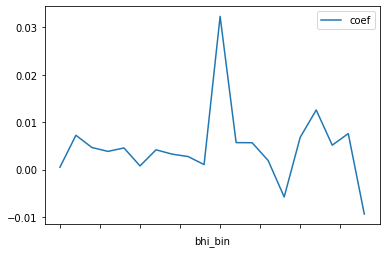

In [86]:
bin_coef.plot('bhi_bin', 'coef')

In [603]:
cnty_Dlogdep = cnty_Dlogdep.merge(ctbhi_bin)

In [605]:
bin_Dlogdep = cnty_Dlogdep.groupby(['year', 'bhi_bin']).Dlogdep.mean().reset_index()

In [606]:
bin_Dlogdep = bin_Dlogdep.merge(feddt)

### Q6

In [103]:
forR = dt[['cntycode', 'year', 'uninumbr', 'Dfedrate', 'FIPS', 'Dlogdep', 'rssdid']]

In [104]:
forR = forR.merge(ctbhi)

In [105]:
forR['FIPS'] = forR.FIPS.astype('int')

In [99]:
forR.to("forstata.dta")